# Example 15: ONNX Export and Deployment

Once you have trained a model, you often want to deploy it without requiring
the full PyTorch/fastai stack. ONNX (Open Neural Network Exchange) is an open
format that lets you run models with lightweight runtimes like ONNX Runtime.
This example exports a trained model to ONNX and verifies numerical agreement
with the PyTorch version.

## Prerequisites

This notebook builds on Examples 00-02. In particular, you should be familiar
with `InferenceWrapper` from Example 02 (numpy-based inference with a trained
model). Make sure ONNX Runtime is installed:

```bash
uv sync --extra dev
```

## Setup

In [1]:
import numpy as np
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.inference import InferenceWrapper
from tsfast.inference.onnx import export_onnx, OnnxInferenceWrapper
from tsfast.learner.losses import fun_rmse

## Train a Model

We train a quick LSTM on the Silverbox benchmark so we have a model to export.
See Example 00 for a detailed walkthrough of this step.

- **`bs=16`** -- batch size
- **`win_sz=500`** -- window length in timesteps
- **`stp_sz=10`** -- stride between consecutive windows
- **`hidden_size=40`** -- number of LSTM hidden units
- **`metrics=[fun_rmse]`** -- track RMSE during training

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
lrn = RNNLearner(dls, rnn_type='lstm', hidden_size=40, metrics=[fun_rmse])
lrn.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.005580,0.005501,0.010377,00:03
1,0.004415,0.005555,0.010505,00:02
2,0.004261,0.004821,0.010069,00:02
3,0.004260,0.005404,0.010453,00:03
4,0.002859,0.002949,0.009490,00:03


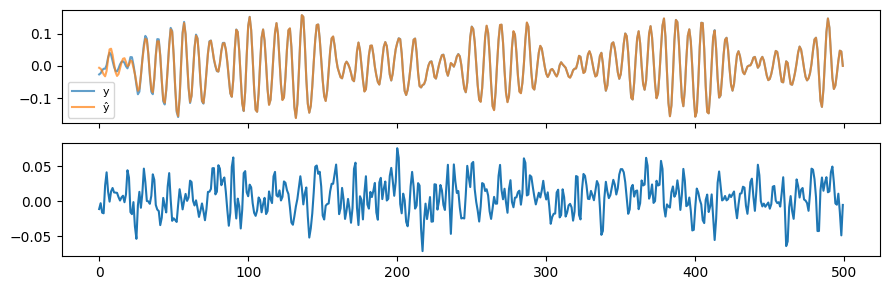

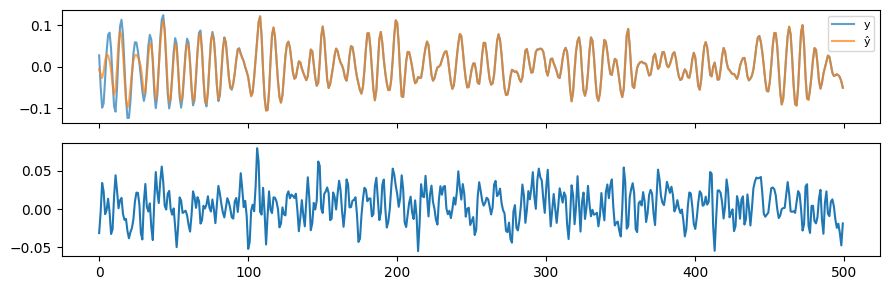

In [3]:
lrn.show_results(max_n=2)

## PyTorch Inference with InferenceWrapper

As covered in Example 02, `InferenceWrapper` provides numpy-in / numpy-out
inference using the PyTorch model. It handles normalization automatically:
raw numpy arrays go in, raw numpy predictions come out.

In [4]:
pytorch_wrapper = InferenceWrapper(lrn)

xb, yb = dls.valid.one_batch()
np_input = xb.cpu().numpy()

y_pytorch = pytorch_wrapper.inference(np_input)
print(f"Input shape:  {np_input.shape}")
print(f"Output shape: {y_pytorch.shape}")

Input shape:  (16, 500, 1)
Output shape: (16, 500, 1)


## Export to ONNX

`export_onnx` converts the trained model to ONNX format. Normalization (input
scaling and output denormalization) is **baked into** the ONNX graph -- the
exported model accepts raw numpy inputs and produces raw outputs, just like
`InferenceWrapper`.

Parameters:

- **`lrn`** -- the trained fastai Learner to export
- **`path`** -- output file path (a `.onnx` suffix is added if missing)
- **`opset_version=17`** (default) -- ONNX operator set version. Higher
  versions support more operations; 17 is a safe default for most runtimes.
- **`seq_len=None`** (default) -- override the sequence length for the dummy
  input used during tracing. By default it uses the window size from the
  DataLoaders. The exported model accepts any sequence length at runtime thanks
  to dynamic axes.

In [5]:
onnx_path = export_onnx(lrn, '/tmp/tsfast_model.onnx')
print(f"Exported to: {onnx_path}")

Exported to: /tmp/tsfast_model.onnx


/home/pheenix/Development/tsfast/.venv/lib/python3.12/site-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:4445: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  return _generic_rnn(


## Load and Run with ONNX Runtime

`OnnxInferenceWrapper` loads the exported ONNX model and provides the same
`.inference()` API as `InferenceWrapper`. Under the hood it uses ONNX Runtime,
a lightweight inference engine that does **not** require PyTorch.

In [6]:
onnx_wrapper = OnnxInferenceWrapper(onnx_path)
y_onnx = onnx_wrapper.inference(np_input)
print(f"ONNX output shape: {y_onnx.shape}")

ONNX output shape: (16, 500, 1)


## Verify Numerical Agreement

The PyTorch and ONNX outputs should be nearly identical. Small floating-point
differences are expected due to different execution backends, but the maximum
absolute difference should be well below 1e-4.

In [7]:
max_diff = np.max(np.abs(y_pytorch - y_onnx))
mean_diff = np.mean(np.abs(y_pytorch - y_onnx))
print(f"Max absolute difference:  {max_diff:.2e}")
print(f"Mean absolute difference: {mean_diff:.2e}")
assert max_diff < 1e-4, f"Outputs differ by {max_diff}"
print("Outputs match within tolerance!")

Max absolute difference:  5.81e-07
Mean absolute difference: 1.13e-07
Outputs match within tolerance!


## Limitations

Autoregressive models (`AR_RNNLearner`, `AR_TCNLearner`) **cannot** be exported
to ONNX. These models contain a sequential loop that feeds predictions back as
input at each timestep, and ONNX does not support dynamic loops of this kind.
If you try to export an autoregressive model, `export_onnx` will raise a
`ValueError` with a clear message.

For autoregressive models, use `InferenceWrapper` instead -- it runs the
prediction loop in Python and works with any model type.

## Key Takeaways

- **`export_onnx` converts trained models to ONNX format** with normalization
  baked into the graph. The exported model accepts raw inputs and produces raw
  outputs.
- **`OnnxInferenceWrapper` provides the same numpy interface** as
  `InferenceWrapper`, making it a drop-in replacement for deployment.
- **ONNX Runtime is lightweight** -- deploy your models without installing
  PyTorch or fastai.
- **Always verify numerical agreement** between PyTorch and ONNX outputs to
  catch export issues early.
- **Autoregressive models cannot be exported** due to their sequential
  prediction loop. Use `InferenceWrapper` for those models instead.